####### 🚀 At the heart of every solution is a model that assumes linearity: THis means that the expected value of the target can be expressed as a weighted sum of features, or conditional mean E[Y | X= x] can be expressed as a weighted sum of the features x 

In [21]:
import math
import time
import numpy as np
import tensorflow as tf
import os
import sys
import pandas as pd
import random

In [22]:
#sys.path.append('../')  # Add parent directory

from d2l import tensorflow as d2l

print("d2l imported successfully!")

d2l imported successfully!


##### 🚀 Linear regression is an affine transformation of input features, which is characterized by linear transformation of features via a weighted sum, combined with a translation via the added bias.

##### 
Note that large differences between estimates 
 and targets 
 lead to even larger contributions to the loss, due to its quadratic form (this quadraticity can be a double-edge sword; while it encourages the model to avoid large errors it can also lead to excessive sensitivity to anomalous data). To measure the quality of a model on the entire dataset of 
 examples, we simply average (or equivalently, sum) the losses on the training set

####
First, we can subsume the bias 
b into the parameter w 
 by appending a column to the design matrix consisting of all 1s. Then our prediction problem is to minimize ||y - Xw||**2 .As long as the design matrix has full rank (no feature is linearly dependent on the others), then there will be just one critical point on the loss surface and it corresponds to the minimum of the loss over the entire domain

####
Unfortunately, SGD has drawbacks, both computational and statistical. One problem arises from the fact that processors are a lot faster multiplying and adding numbers than they are at moving data from main memory to processor cache. It is up to an order of magnitude more efficient to perform a matrix–vector multiplication than a corresponding number of vector–vector operations. This means that it can take a lot longer to process one sample at a time compared to a full batch

In [23]:
## vectorization for speed
n= 10000
a = tf.ones(n)
b = tf.ones(n)

In [24]:
c = tf.Variable(tf.zeros(n))
t= time.time()
for i in range(n):
    c[i].assign(a[i] + b[i])

print(f"time taken {time.time() - t:.9f} seconds")

time taken 3.708468914 seconds


In [25]:
t= time.time()
d= a + b
print(f"time taken {time.time() - t:.9f} seconds")

time taken 0.001015186 seconds


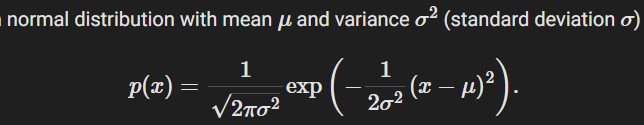

In [26]:
def normal(x, mu, sigma):
    p = 1/ math.sqrt(2* math.pi * sigma**2)
    return p* np.exp(-0.5 * (x - mu)**2 /sigma**2)

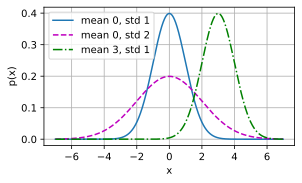

In [27]:
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]

d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

#### 
the likelihood of seeing a particular y for a given x is 
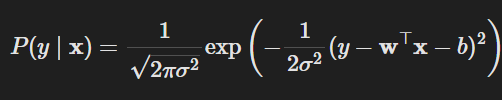

In [28]:
class A:
    def __init__(self):
        self.b = 1

a = A()

@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


In [29]:
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore= ['c'])
        print("self.a = ", self.a, 'self.b =', self.b)
        print("there is no self.c = ", not hasattr(self, 'c'))

b= B(a=1, b=2, c= 3)

self.a =  1 self.b = 2
there is no self.c =  True


In [30]:
class ProgressBoard(d2l.HyperParameters):  #@save
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

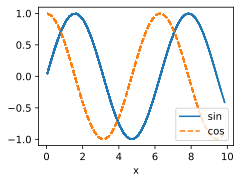

In [31]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=2)

#####
The first, __ init __, stores the learnable parameters, the training_step method accepts a data batch to return the loss value, and finally, configure_optimizers returns the optimization method, or a list of them, that is used to update the learnable parameters. Optionally we can define validation_step to report the evaluation measures

In [32]:
class Module(tf.keras.Model, d2l.HyperParameters):  #@save
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
        self.training = None

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def call(self, X, *args, **kwargs):
        if kwargs and "training" in kwargs:
            self.training = kwargs['training']
        return self.forward(X, *args)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.numpy(), (
            'train_' if train else 'val_') + key, every_n=int(n))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

In [33]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data'):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

In [34]:
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

In [35]:
class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = tf.random.normal((n, w.shape[0]))
        noise = tf.random.normal((n, 1)) * noise
        self.y = tf.matmul(self.X, tf.reshape(w, (-1, 1))) + b + noise

In [42]:
data = SyntheticRegressionData(w=tf.constant([2, -3.4]), b=4.2)


In [43]:
print('features:', data.X[0],'\nlabel:', data.y[0])


features: tf.Tensor([ 1.5430677 -1.7732583], shape=(2,), dtype=float32) 
label: tf.Tensor([13.310433], shape=(1,), dtype=float32)


In [45]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        j = tf.constant(indices[i : i+self.batch_size])
        yield tf.gather(self.X, j), tf.gather(self.y, j)

In [55]:
for m in dir(SyntheticRegressionData):
    if not m.startswith("__"):
        print(m)

get_dataloader
get_tensorloader
save_hyperparameters
train_dataloader
val_dataloader


In [56]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    shuffle_buffer = tensors[0].shape[0] if train else 1
    return tf.data.Dataset.from_tensor_slices(tensors).shuffle(
        buffer_size=shuffle_buffer).batch(self.batch_size)

@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [57]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: (32, 2) 
y shape: (32, 1)


In [58]:
len(data.train_dataloader())

32